# FIDE & Google Efficient Chess AI Challenge

Welcome! This notebook will familiarize you with using competition's environment, creating an agent, and submitting your first chess bot!

In [1]:
# first let's make sure you have internet enabled
import requests
requests.get('http://www.google.com', timeout=10).ok

True

#### If you don't have internet access (it doesn't say "True" above)
1. make sure your account is Phone Verified in [account settings](https://www.kaggle.com/settings)
2. make sure internet is turned on in Settings -> Turn on internet

In [2]:
%%capture
# ensure we are on the latest version of kaggle-environments
%pip install --upgrade kaggle-environments

In [21]:
import time

In [3]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)


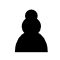
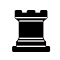
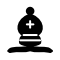
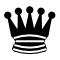
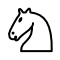
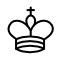
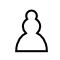
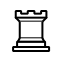
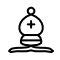
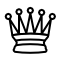
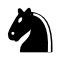
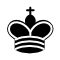

In [4]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000) 

### Creating your first agent
Now let's create your first agent! The environment has the [Chessnut](https://github.com/cgearhart/Chessnut) pip package installed and we'll use that to parse the board state and generate moves.

In [ ]:
%%writefile main.py
from Chessnut import Game
import random
import time
from concurrent.futures import ThreadPoolExecutor

# Define piece values for material evaluation
PIECE_VALUES = {'p': 1, 'n': 3, 'b': 3, 'r': 5, 'q': 9, 'k': 0, ' ': 0}

# Define an opening book
OPENINGS = {
    # King's Pawn Opening
    "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1": "e2e4",
    "rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1": "e7e5",

    # Sicilian Defense
    "rnbqkbnr/pppppppp/8/8/8/4P3/PPPP1PPP/RNBQKBNR b KQkq - 0 1": "c7c5",
    "rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR w KQkq c6 0 2": "g1f3",

    # French Defense
    "rnbqkbnr/pppppppp/8/8/8/4P3/PPPP1PPP/RNBQKBNR b KQkq - 0 1": "e7e6",
    "rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq e6 0 2": "d2d4",

    # Queen's Gambit
    "rnbqkbnr/pppppppp/8/8/8/3P4/PPP1PPPP/RNBQKBNR b KQkq - 0 1": "d7d5",
    "rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq d5 0 2": "c2c4",
    "rnbqkbnr/pp1ppppp/8/2p5/2PP4/8/PP2PPPP/RNBQKBNR b KQkq c3 0 2": "e7e6",

    # King's Indian Defense
    "rnbqkbnr/pppppppp/8/8/8/3P4/PPP1PPPP/RNBQKBNR b KQkq - 0 1": "g8f6",
    "rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq f6 0 2": "c2c4",
    "rnbqkbnr/pppppppp/8/8/2PP4/8/PP3PPP/RNBQKBNR b KQkq c3 0 2": "g7g6",

    # Caro-Kann Defense
    "rnbqkbnr/pppppppp/8/8/8/4P3/PPPP1PPP/RNBQKBNR b KQkq - 0 1": "c7c6",
    "rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR w KQkq c6 0 2": "d2d4",

    # Italian Game
    "rnbqkbnr/pppppppp/8/8/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2": "b8c6",
    "r1bqkbnr/pppppppp/2n5/8/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3": "f1c4",

    # Ruy-Lopez
    "rnbqkbnr/pppppppp/8/8/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2": "b8c6",
    "r1bqkbnr/pppppppp/2n5/1B6/4P3/5N2/PPPP1PPP/RNBQK2R b KQkq - 2 3": "a7a6",

    # English Opening
    "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1": "c2c4",
    "rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR b KQkq c3 0 1": "e7e5",

    # Scandinavian Defense
    "rnbqkbnr/pppppppp/8/8/8/4P3/PPPP1PPP/RNBQKBNR b KQkq - 0 1": "d7d5",
    "rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq d6 0 2": "e4e5",

    # Alekhine Defense
    "rnbqkbnr/pppppppp/8/8/8/4P3/PPPP1PPP/RNBQKBNR b KQkq - 0 1": "g8f6",
    "rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq f6 0 2": "e4e5",
}

# Initialize transposition table
transposition_table = {}

def evaluate_capture(game, move):
    """
    Evaluate the value of a capture move based on the piece being captured.
    """
    target_square = Game.xy2i(move[2:4])
    target_piece = game.board.get_piece(target_square).lower()
    return PIECE_VALUES.get(target_piece, 0)

def prioritize_promotion(moves):
    """
    Filter and prioritize pawn promotion moves.
    """
    promotion_moves = [move for move in moves if move[-1].lower() in ('q', 'r', 'b', 'n')]
    if promotion_moves:
        return max(promotion_moves, key=lambda move: PIECE_VALUES.get(move[-1].lower(), 9))
    return None

def prioritize_promotion(moves):
    """
    Filter and prioritize pawn promotion moves.
    """
    promotion_moves = [move for move in moves if move[-1].lower() in ('q', 'r', 'b', 'n')]
    if promotion_moves:
        return max(promotion_moves, key=lambda move: PIECE_VALUES.get(move[-1].lower(), 9))
    return None

def minimax(game, depth, is_maximizing, alpha, beta, start_time, time_limit=0.9):
    """
    Minimax algorithm with Alpha-Beta pruning and time management.
    """
    # Check for time limit
    elapsed_time = time.time() - start_time
    if elapsed_time >= time_limit:
        print("Time exceeded during Minimax; exiting early.")
        return evaluate_board_with_cache(game), None

    # Base cases
    if depth == 0 or game.status in (Game.CHECKMATE, Game.STALEMATE):
        return evaluate_board_with_cache(game), None

    legal_moves = list(game.get_moves())
    if not legal_moves:
        return evaluate_board_with_cache(game), None

    legal_moves = sorted(legal_moves, key=lambda move: evaluate_capture(game, move), reverse=True)

    if is_maximizing:
        best_score = -float('inf')
        best_move = None
        for move in legal_moves:
            g = Game(game.get_fen())
            g.apply_move(move)
            score, _ = minimax(g, depth - 1, False, alpha, beta, start_time, time_limit)
            if score > best_score:
                best_score = score
                best_move = move
            alpha = max(alpha, best_score)
            if beta <= alpha:
                break  # Alpha-beta pruning
        return best_score, best_move
    # Minimizing player
    else:
        best_score = float('inf')
        best_move = None
        for move in legal_moves:
            g = Game(game.get_fen())
            g.apply_move(move)
            score, _ = minimax(g, depth - 1, True, alpha, beta, start_time, time_limit)
            if score < best_score:
                best_score = score
                best_move = move
            beta = min(beta, best_score)
            if beta <= alpha:
                break  # Alpha-beta pruning
        return best_score, best_move

def evaluate_board_with_cache(game):
    """
    Evaluate the current board state with caching to avoid redundant computations.
    """
    fen = game.get_fen()
    if fen in transposition_table:
        return transposition_table[fen]
    
    # Compute evaluation and cache it
    evaluation = evaluate_board(game)
    transposition_table[fen] = evaluation
    return evaluation

def evaluate_board(game):
    """
    Evaluate the current board state.
    """
    fen = game.get_fen()
    board = fen.split()[0]
    score = 0
    for char in board:
        if char.isalpha():
            piece_value = PIECE_VALUES.get(char.lower(), 0)
            score += piece_value if char.isupper() else -piece_value
    return score

def generate_bitboards(game):
    """
    Generate bitboards for the current board state.
    """
    fen = game.get_fen().split()[0]
    bitboards = {piece: 0 for piece in "pnbrqkPNBRQK"}
    square_index = 63

    for char in fen:
        if char.isdigit():
            square_index -= int(char)
        elif char.isalpha():
            bitboards[char] |= 1 << square_index
            square_index -= 1
    return bitboards

def parallel_minimax(game, depth, is_maximizing, alpha, beta, start_time, time_limit):
    """
    Minimax with Alpha-Beta pruning and parallel move evaluation.
    """
    if time.time() - start_time > time_limit:
        return evaluate_board_with_cache(game), None

    if depth == 0 or game.status in (Game.CHECKMATE, Game.STALEMATE):
        return evaluate_board_with_cache(game), None

    legal_moves = list(game.get_moves())
    if not legal_moves:
        return evaluate_board_with_cache(game), None

    def evaluate_move(move):
        g = Game(game.get_fen())
        g.apply_move(move)
        score, _ = minimax(g, depth - 1, not is_maximizing, alpha, beta, start_time, time_limit)
        return move, score

    with ThreadPoolExecutor() as executor:
        results = executor.map(evaluate_move, legal_moves)

    if is_maximizing:
        best_score = -float('inf')
        best_move = None
        for move, score in results:
            if score > best_score:
                best_score = score
                best_move = move
            alpha = max(alpha, best_score)
            if beta <= alpha:
                break
        return best_score, best_move
    else:
        best_score = float('inf')
        best_move = None
        for move, score in results:
            if score < best_score:
                best_score = score
                best_move = move
            beta = min(beta, best_score)
            if beta <= alpha:
                break
        return best_score, best_move

def iterative_deepening(game, max_depth, time_limit, start_time):
    """
    Perform iterative deepening to find the best move within a time limit.
    """
    best_move = None
    depth_time_allocation = time_limit / max_depth  # Allocate equal time per depth

    for depth in range(1, max_depth + 1):
        remaining_time = time_limit - (time.time() - start_time)
        if remaining_time <= 0:
            print("Time exceeded before completing iterative deepening.")
            break

        depth_time_limit = min(depth_time_allocation, remaining_time)
        print(f"Depth {depth}: Allocated time {depth_time_limit:.2f} seconds, Remaining time {remaining_time:.2f} seconds")
        
        try:
            _, move = minimax(
                game, depth, is_maximizing=True, alpha=-float('inf'), beta=float('inf'),
                start_time=start_time, time_limit=depth_time_limit
            )
            if move:
                best_move = move
        except TimeoutError:
            print(f"Depth {depth}: Time exceeded during search.")
            break

    return best_move if best_move else fallback_move(game)

def chess_bot(obs):
    """
    Improved chess bot with optimizations for caching, bitboards, and parallel processing.
    """
    start_time = time.time()
    game = Game(obs.board)

    # Opening book move
    if game.get_fen() in OPENINGS:
        return OPENINGS[game.get_fen()]

    # Iterative deepening
    best_move = iterative_deepening(game, max_depth=3, time_limit=0.5, start_time=start_time)
    if best_move:
        return best_move

    # Fallback move
    return fallback_move(game)

Overwriting main.py


### Testing your agent

Now let's see how your agent does againt the random agent!

Depth 1: Allocated time 0.17 seconds, Remaining time 0.50 seconds
Depth 2: Allocated time 0.17 seconds, Remaining time 0.48 seconds
Time exceeded during Minimax; exiting early.
Depth 3: Allocated time 0.17 seconds, Remaining time 0.33 seconds
Time exceeded during Minimax; exiting early.
Depth 1: Allocated time 0.17 seconds, Remaining time 0.50 seconds
Depth 2: Allocated time 0.17 seconds, Remaining time 0.48 seconds
Time exceeded during Minimax; exiting early.
Time exceeded during Minimax; exiting early.
Depth 3: Allocated time 0.17 seconds, Remaining time 0.33 seconds
Time exceeded during Minimax; exiting early.
Depth 1: Allocated time 0.17 seconds, Remaining time 0.50 seconds
Depth 2: Allocated time 0.17 seconds, Remaining time 0.48 seconds
Time exceeded during Minimax; exiting early.
Time exceeded during Minimax; exiting early.
Time exceeded during Minimax; exiting early.
Depth 3: Allocated time 0.17 seconds, Remaining time 0.33 seconds
Time exceeded during Minimax; exiting early.
D


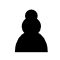
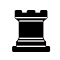
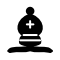
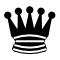
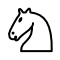
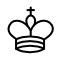
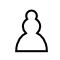
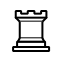
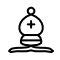
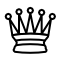
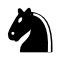
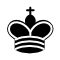

In [81]:
from kaggle_environments import make
env = make("chess", debug=True)

result = env.run(["main.py", "random"])

for i, agent in enumerate(result[-1]):
    print(f"Agent {i}: {agent.status} / Reward: {agent.reward}")

env.render(mode="ipython", width=800, height=800)